In [1]:
import sys
sys.path.insert(0, r"C:\Users\sama\Desktop\huobi")
import warnings
import pandas as pd
import numpy as np
from datetime import datetime
from data.dbengine import get_db_engine
from data.dbengine import get_db_klines
import backtest.backtest as bt
import backtest.backtest_analyse as ba
import CTA.CTA_signal as sg
import CTA.costant as cs
import pickle
import matplotlib.pyplot as plt
import CTA.help_function as hf
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
from joblib import Parallel, delayed
import statistics 
engine = get_db_engine('data', 'hbdata')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

market_data_folder_1h = cs.market_data_folder_1h
start_index = 0
plt.ioff()

In [2]:
len(cs.pair_list)

29

In [3]:
# align all data
data_price = pd.DataFrame()
for symbol in cs.pair_list:
    data = pd.read_pickle('{0}/{1}.pkl'.format(market_data_folder_1h, symbol))
    data_price = pd.concat([data_price, data.close], axis=1)
data_price.columns = cs.pair_list
data_price.to_pickle('{}/pair_combined_close.pkl'.format(market_data_folder_1h))

# 8h

In [4]:
data_price = pd.read_pickle('{}/pair_combined_close.pkl'.format(market_data_folder_1h))
data_price = data_price[start_index:-1:8]

# Functions

In [5]:
def cal_ols(data,adf_threshold=-2):
    
    x = data.iloc[:,0]
    y = data.iloc[:,1] 

    if x.isnull().sum(axis = 0) > 0 or y.isnull().sum(axis = 0) > 0:
        return float('NaN'),float('NaN'),float('NaN')
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()
    influence = results.get_influence()
    result = adfuller(results.resid)
    
    beta = results.params[1]
    d = adf_threshold - result[0]
    sr = influence.resid_studentized_internal[-1]
    asr = abs(sr)
    ps = asr**d
    return beta,sr,ps

In [6]:
def cal_factor(data,adf_threshold, window_size):
    factor = pd.DataFrame(index = data.index, columns = ['beta','sr','ps'])
    for i in range(window_size-1,len(data)):
        factor.iloc[i,0], factor.iloc[i,1], factor.iloc[i,2] = cal_ols(data.iloc[i+1-window_size:i+1,:])
    return factor

# Calculate Factors (beta, SR, Power Statistics)

In [7]:
factors = {}

In [8]:
import threading
def process_factor(start_pos: int):
    while start_pos < len(cs.pair_list):
        print(cs.pair_list[start_pos])
        factors[cs.pair_list[start_pos]] = {}
        for j in range(start_pos+1,len(cs.pair_list)):
            data_combine = data_price[[cs.pair_list[start_pos],cs.pair_list[j]]]
            factors[cs.pair_list[start_pos]][cs.pair_list[j]] = cal_factor(data_combine.pct_change(),-2,120)
            print(cs.pair_list[start_pos],cs.pair_list[j])
        start_pos += 8
threads = []
for i in range(8):
    threads.append(threading.Thread(target=process_factor, args=(i,)))
for thread in threads:
    thread.start()
thread.join()    

ADA
ATOM
BAT
BCH
COMP
DOT
EOS
ETC
OMG
NEO
XLM
WAVES
IOST
ZIL
QTUM
ONT
LTC
LINK
ETH
XRP
XMR
TRX
VET
UNI
YFII
THETA
YFI
ZEC
XTZ


In [ ]:
# for i in range(2,len(cs.pair_list)):
#     factors[cs.pair_list[i]] = {}
#     for j in range(i+1,len(cs.pair_list)):
#         data_combine = data_price[[cs.pair_list[i],cs.pair_list[j]]]
#         factors[cs.pair_list[i]][cs.pair_list[j]] = cal_factor(data_combine.pct_change(),-2,240)
#         print(cs.pair_list[i],cs.pair_list[j])

In [63]:
factors['ATOM']['LINK'].tail(200)

,beta,sr,ps
2020-10-10 08:00:00,0.586239,0.726129,0.279734
2020-10-10 16:00:00,0.58658,-0.29341,0.00710348
2020-10-11 00:00:00,0.587242,-0.721807,0.261411
2020-10-11 08:00:00,0.58056,-1.12548,1.62985
2020-10-11 16:00:00,0.582255,-0.151555,0.000415928
2020-10-12 00:00:00,0.581798,-0.234225,0.0024818
2020-10-12 08:00:00,0.581077,-0.359061,0.0146944
2020-10-12 16:00:00,0.579713,1.56913,6.65351
2020-10-13 00:00:00,0.578606,0.265808,0.00366846
2020-10-13 08:00:00,0.579613,0.190992,0.000899454


# Save factors into pickle

In [9]:
#### Save factors into pickle
import pickle
with open('{}/factors_8h_2_120.pkl'.format(market_data_folder_1h), 'wb') as fp:
   pickle.dump(factors, fp)

# Read factors from pickle

In [27]:
with open('{}/factors_8h_2_240.pkl'.format(market_data_folder_1h), 'rb') as fp:
    temp = pickle.load(fp)

In [28]:
temp['ATOM']

{'BAT':                          beta         sr           ps
 2018-11-01 00:00:00       NaN        NaN          NaN
 2018-11-01 08:00:00       NaN        NaN          NaN
 2018-11-01 16:00:00       NaN        NaN          NaN
 2018-11-02 00:00:00       NaN        NaN          NaN
 2018-11-02 08:00:00       NaN        NaN          NaN
 ...                       ...        ...          ...
 2020-12-14 08:00:00  0.556161  -0.209735  5.65292e-05
 2020-12-14 16:00:00  0.555741   0.610418    0.0444604
 2020-12-15 00:00:00  0.550398  -0.598331    0.0393693
 2020-12-15 08:00:00  0.562649   0.766009     0.186496
 2020-12-15 16:00:00  0.562667  0.0686341  4.50604e-08
 
 [2328 rows x 3 columns],
 'BCH':                          beta        sr           ps
 2018-11-01 00:00:00       NaN       NaN          NaN
 2018-11-01 08:00:00       NaN       NaN          NaN
 2018-11-01 16:00:00       NaN       NaN          NaN
 2018-11-02 00:00:00       NaN       NaN          NaN
 2018-11-02 08:00:00       N

# Calculate positon

In [10]:
pos = pd.DataFrame(0,index = data_price.index, columns = cs.pair_list)
threshold = 1.5
for i in range(len(cs.pair_list)):
    for j in range(i+1,len(cs.pair_list)):
        
        temp_beta1 = factors[cs.pair_list[i]][cs.pair_list[j]][['beta']].values*\
        ((factors[cs.pair_list[i]][cs.pair_list[j]][['sr']]>0).astype(float) - 0.5).values*2*\
        (factors[cs.pair_list[i]][cs.pair_list[j]][['ps']]> threshold).astype(float).values
        
        temp_beta1 = pd.Series(temp_beta1[:,0], index = data_price.index).fillna(0)
        pos.loc[:,cs.pair_list[i]] += temp_beta1
        
        temp_beta2 = ((factors[cs.pair_list[i]][cs.pair_list[j]][['sr']]<=0).astype(float) - 0.5).values*2*\
        (factors[cs.pair_list[i]][cs.pair_list[j]][['ps']]> threshold).astype(float).values
        
        temp_beta2 = pd.Series(temp_beta2[:,0], index = data_price.index).fillna(0)
        pos.loc[:,cs.pair_list[j]] += temp_beta2

In [11]:
pos

,ADA,ATOM,BAT,BCH,COMP,DOT,EOS,ETC,ETH,IOST,LINK,LTC,NEO,OMG,ONT,QTUM,THETA,TRX,UNI,VET,WAVES,XLM,XMR,XRP,XTZ,YFI,YFII,ZEC,ZIL
2018-11-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2018-11-01 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2018-11-01 16:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2018-11-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2018-11-02 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-14 08:00:00,0.938188,0.642185,0.423418,1.125902,0.579127,1.082626,1.333123,1.100634,0.547650,0.839577,1.116783,0.756217,0.471331,0.706249,5.901964,0.157935,0.967279,1.385186,0.469442,0.813754,0.282276,0.452304,-26.001271,1.341136,-23.0,1.0,1.0,1.0,1.0
2020-12-14 16:00:00,0.626507,0.798774,-0.435488,0.685557,0.000000,-0.407389,-0.567892,3.775493,0.000000,0.000000,0.664906,0.000000,-10.883902,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0
2020-12-15 00:00:00,1.360376,-7.842423,0.464548,3.648145,-6.544535,3.055398,1.180033,1.138221,3.495023,0.324645,3.104879,0.719425,6.196133,0.607227,1.060756,3.012578,-15.104980,1.585705,0.221307,3.341088,0.088751,1.179081,-19.863637,3.000000,3.0,0.0,0.0,0.0,0.0
2020-12-15 08:00:00,-2.323947,3.584787,-0.004382,-7.443701,4.256627,1.327855,1.931312,0.228509,2.762840,-8.661572,-2.495796,-2.327909,-0.523274,0.306013,-0.451539,0.375339,2.221756,1.241581,-9.954934,2.653071,-0.091433,-0.178653,21.419811,1.000000,0.0,0.0,1.0,-1.0,0.0


# Backtest

In [12]:
data_price_4h = data_price
target_portfolio_4h = pos.copy()

########################## use 1h data ####################################
data_price_1h = pd.read_pickle('{}/combined_close.pkl'.format(market_data_folder_1h))
target_portfolio_4h_share = target_portfolio_4h/data_price_4h # combined

target_portfolio_4h_share.fillna(0, inplace=True)

temp_df = pd.DataFrame(index=data_price_1h.index)
target_portfolio_4h_share = pd.concat([target_portfolio_4h_share, temp_df], axis=1)
target_portfolio_4h_share.ffill(inplace=True)
target_portfolio_4h_share.fillna(0, inplace=True)

# 
bt_result_4h = bt.backtest(data_price_1h,
                        target_portfolio_4h_share,
                        target_as_share=True,
                        cost_bps=0,  # trading cost model in bps
                        fin_bps=0.0,  # financial cost model in bps
                        delay_day_execution=0)  # need to change to 1 if want to test for result 1 hour delay
                        # delay_day_execution=1)  # need to change to 1 if want to test for result 1 hour delay
bt_stats_all_4h = ba.statistics(bt_result_4h, trading_bars_year=365 * 24)
print(bt_stats_all_4h)

index                All      2018      2019      2020
ret_pct           91.45%    426.0%    98.78%    78.52%
ret_pct_maxbs     15.19%    53.96%    20.95%    18.06%
volat_pct         64.11%    95.05%     61.2%    59.41%
sharpe           1.42651   4.48176   1.61398   1.32168
tvr              10.9909   2.38335   8.46567   15.1319
tvr_rate          20.12%    20.78%    20.31%     20.0%
rot_bps          5.18889   23.3984   5.55225   4.48108
daily_pnl       0.136874   0.13384  0.112808  0.162738
daily_volat      1.83312  0.570536   1.33533   2.35238
mdd             -37.3643   -1.6152  -17.5745  -37.3643
booksize         54.6299   11.4675   41.6834   75.6449
abs_booksize     54.6299   11.4675   41.6834   75.6449
max_booksize     328.944   90.5345   196.582   328.944
min_booksize           0         0         0         0
gini_coef         1.3391    0.6688    0.9405    1.6445
gini_negative     0.6694    0.6667    0.6166    0.6364
Month_winratio     69.0%     33.0%     77.0%     58.0%
Week_winra

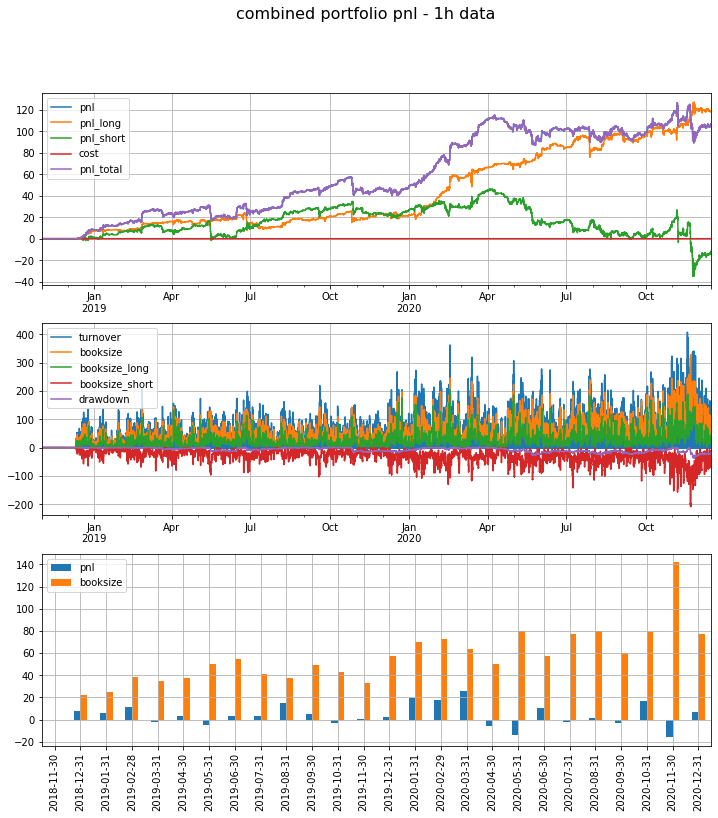

In [13]:
ba.plot_pnl_portfolio(bt_result_4h, title="combined portfolio pnl - 1h data")
plt.show()